In [190]:
# Simple demonstration of back-propagation
import math

In [355]:
class Value:
    def __init__(self, value, _op='', _children=(), label=''):
        self.value = value
        self.label = label
        
        # _op = operation
        self._op = _op

        # children (previous operands)
        self._prev = set(_children)

        # gradient variable that maintains the value: derivative of L (output) with respect to self
        self.grad = 0.0

        # back propagation
        self._backward = lambda : None # default : nothing



    def __add__(self, other_value):
        out = Value(self.value + other_value.value, '+', (self, other_value))
        
        def _backward():
            # local derivative * out
            self.grad =  1.0 * out.grad
            other_value.grad = 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other_value):
        out = Value(self.value * other_value.value, '*', (self, other_value))

        def _backward():
            #            local derivative * out
            self.grad = (other_value.value * out.grad)
            other_value.grad = (self.value * out.grad)

        out._backward = _backward
        
        return out
        
    # activation function
    def tanh(self):
        x = self.value
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, _op='tanh', _children=(self,))

        def _backward():
            self.grad = (1-t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        print("Im at the start")

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            print(node)
            node._backward()
        

    def __repr__(self):
        return f"Value(data={self.value}"


In [133]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')


# Now we want to be able to add and multiply values (important for later)
# And we want to keep track of the operations between different Values

In [134]:
d = a + b
d.label = 'd'
d._op

'+'

In [135]:
# Now we want to keep track of children (previous operations with previous values)


In [136]:
f = a*b + c
f.label = 'f'
f._prev

{Value(data=-6.0, Value(data=10}

In [137]:
# Visualize the operations with a tree
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # l -> R

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # create rectangular record node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot
    

In [138]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')

# output
L = d*f; L.label='L'

# Using a forward pass we can build out a mathematical expression
# Output of Forward Pass: L : -8.000


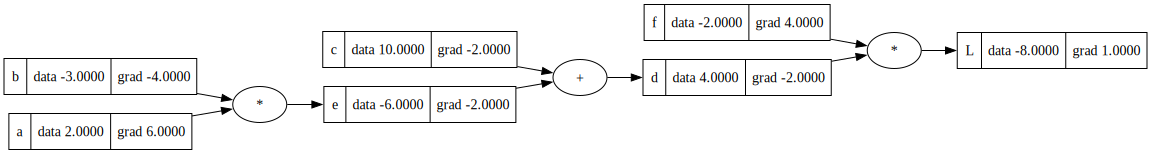

In [178]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
draw_dot(L)

In [248]:
# Try to make L go up
# Gradient provides the direction of highest increase, so we just need to go in the direciton of the gradient
a.value += 0.01 * a.grad
b.value += 0.01 * b.grad
c.value += 0.01 * c.grad
f.value += 0.01 * f.grad

e = a*b
d = e+c

# output
L = d*f
print(L.value)

-47.153495048604356


In [169]:
# Back Propagation:


# I.    Start at L (the output of the forward pass), and reverse
# II.   Calculate the gradient along all the intermediate values
# III.  For every single (intermediate) value, compute the derivative of that node with RESPECT to L. Basically, "How much will L change if we change the ___ node" dL/dNode

In [167]:
def calculate_derivative_manually():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')

    # output
    L = d*f; L.label='L'
    L1 = L.value

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10+h, label='c')
    e = Value(((a*b).value)); e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')

    # output
    L = d*f; L.label='L'
    L2 = L.value

    #             [f(x+h)-(fx)] / h
    derivative = ((L2-L1))/h
    print(derivative)
calculate_derivative_manually()

-1.9999999999953388


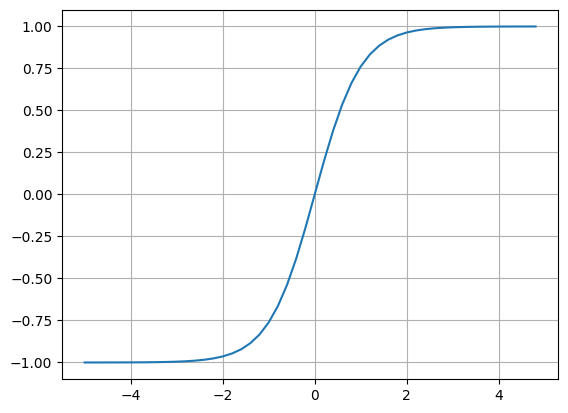

In [186]:
import matplotlib.pyplot as plt
import numpy as np
# ill use tanh activation func
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [349]:
# Test inputs, x1, x2 (2 dimensional neuron)

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# forward pass 1
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

# forward pass 2
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = '(x1*w1) + (x2*w2)'


n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o' # requires exponentiation


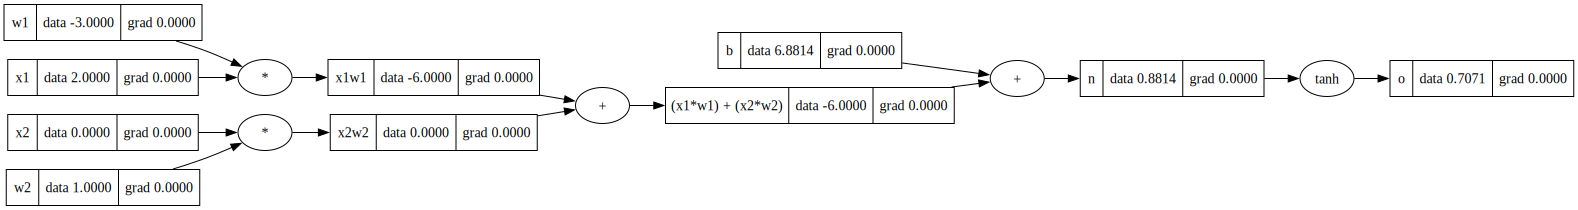

In [350]:
draw_dot(o)

In [356]:
o.backward(o)

In [348]:
# o.grad = 1.0

In [304]:
# o._backward()

In [305]:
# n._backward()

In [306]:
# b._backward() # Defaults to none

In [307]:
# x1w1x2w2._backward()

In [308]:
# x2w2._backward()

In [309]:
# x1w1._backward()

In [287]:
# x2.grad = w2.value * x2w2.grad
# w2.grad = x2.value * x2w2.grad

# w1.grad = x1.value * x1w1.grad
# x2.grad = w1.value * x1w1.grad

# o = tanh(n)
# do/dn ? 

# derivative of tanh = 1 - tanh^2(n)
# do/dn = 1 - tanh(n) ** 2
# do/dn = 1 - o **2
# do/dn:
# 1 - o.value ** 2



In [318]:
# build topological graph
# --> moved to Value class

In [319]:
topo # L -> R

[Value(data=0.0,
 Value(data=1.0,
 Value(data=0.0,
 Value(data=2.0,
 Value(data=-3.0,
 Value(data=-6.0,
 Value(data=-6.0,
 Value(data=6.881373587019543,
 Value(data=0.8813735870195432,
 Value(data=0.7071067811865476]